In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
from matplotlib.lines import Line2D
import matplotlib.pylab as plb
from sklearn.linear_model import LinearRegression
import matplotlib.style as style
from matplotlib.patches import Patch

data_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Data/"
plot_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Plots/"

pd.set_option('display.max_columns', 500)

In [2]:
#uploading data 
equity_remind=pd.read_excel(data_path+'REMIND_equity_analysis.xls')
equity_image=pd.read_excel(data_path+'IMAGE_equity_analysis.xls')
allmodels_df=pd.read_excel(data_path+'MASTERDF_equity_analysis.xls') #master datafram with all regions from IMAGE and REMIND
allmodels_equal_df=pd.read_excel(data_path+'allmodels_df.xls') #consolidated with REMIND regions

In [3]:
regions_rem = ['AFR', 'CHN', 'EUR', 'IND', 'JPN', 'LAM', 'MEA', 'OAS', 'ROW', 'RUS', 'USA', 'World']
regions_ima = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR',
 'USA', 'WAF', 'WEU', 'World']
regions_rem_noworld = ['AFR', 'CHN', 'EUR', 'IND', 'JPN', 'LAM', 'MEA', 'OAS', 'ROW', 'RUS', 'USA']
regions_ima_noworld = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR',
 'USA', 'WAF', 'WEU']
remind_scens=['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP1-26-SPA1-V17',
              'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP5-26-SPA5-V17']
image_scens=['SSP1-19-SPA0-V17', 'SSP2-LF-SPA2-V17']

In [4]:
allmodels_df[(allmodels_df.Region==('World'))&(allmodels_df.Year==2100)]['CUM_BECCS'].median()

726712.6599999999

In [5]:
allmodels_df[(allmodels_df.Region==('World'))&(allmodels_df.Year==2100)]['BECCS'].median()

14943.119999999999

# Leakage Calculation
### 2100 cumulative BECCS transferred amount based on 2 schemes * 5%, 10%, 15%, 20%, 25%

In [ ]:
VariablesOI=['CUM_BECCS_model_vs_fair_share_by_CUM_POP',
 'CUM_BECCS_model_vs_fair_share_by_GDP',
 'CUM_BECCS_invest_model_vs_FairShare_by_POP',
 'CUM_BECCS_invest_model_vs_FairShare_by_GDP']

In [10]:
#this function basically sums up the 2100 cumulative difference between CUM_CDR according to model
# and fair share CUM_POP according to equity calculation (if difference is POSITIVE)

def total_excess_BECCS_by_CUM_POP_Gt(equity_df, scenario):
    scen = scenario
    rfilt_wo_world=(equity_df.Region!='World')  
    scen_filt = (equity_df.Scenario == scen)
    for yr in equity_df.Year.unique():
        yrfilt=(equity_df.Year==yr)
        excdrfilt_POP=(equity_df.CUM_BECCS_model_vs_fair_share_by_CUM_POP>0)&rfilt_wo_world&yrfilt&scen_filt

    tot_exs_BECCS_by_CUM_POP = equity_df.loc[excdrfilt_POP,'CUM_BECCS_model_vs_fair_share_by_CUM_POP'
                                            ].sum()*10**-3
    return(tot_exs_BECCS_by_CUM_POP)

def total_excess_BECCS_by_GDP_Gt(equity_df, scenario):
    scen = scenario
    rfilt_wo_world=(equity_df.Region!='World')  
    scen_filt = (equity_df.Scenario == scen)
    for yr in equity_df.Year.unique():
        yrfilt=(equity_df.Year==yr)
        excdrfilt_POP=(equity_df.CUM_BECCS_model_vs_fair_share_by_GDP>0)&rfilt_wo_world&yrfilt&scen_filt

    tot_exs_BECCS_by_GDP = equity_df.loc[excdrfilt_POP,'CUM_BECCS_model_vs_fair_share_by_GDP'
                                        ].sum()*10**-3
    return(tot_exs_BECCS_by_GDP)

In [12]:
#get total transferred BECCS amount by 2100 (sum of positive differences between the fair share and modelled value)
def create_BECCS_CO2_transfer_table(equity_df):
    scens=equity_df.Scenario.unique()
    transfer_df=pd.DataFrame(columns=['Model','Scenario', 'Total transferred: AP',
                                      'Total transferred: CPCE', 'Unit'])  
    #transfer_df['Unit']='billion US$2005'
    transfer_df['Scenario']=scens
    transfer_df['Model']=equity_df['MODEL']
    
    for i in np.arange(0,len(scens)):
        transfer_df.loc[i,'Total transferred: AP']=total_excess_BECCS_by_GDP_Gt(equity_df, scens[i]) #this is how much money that will be trasnferred worldwide
        transfer_df.loc[i,'Total transferred: CPCE']=total_excess_BECCS_by_CUM_POP_Gt(equity_df, scens[i]) 
        transfer_df.loc[i,'Unit']='Gt'
    
    return transfer_df

BECCS_leakage_image=create_BECCS_CO2_transfer_table(equity_image)
BECCS_leakage_remind=create_BECCS_CO2_transfer_table(equity_remind)
BECCS_leakage_allmodels=pd.concat([BECCS_leakage_image,BECCS_leakage_remind])
BECCS_leakage_allmodels

,Model,Scenario,Total transferred: AP,Total transferred: CPCE,Unit
0,IMAGE,SSP1-19-SPA0-V17,192.759,144.138,Gt
1,IMAGE,SSP2-LF-SPA2-V17,315.034,277.872,Gt
0,REMIND,SSP1-19-SPA1-V17,239.078,304.868,Gt
1,REMIND,SSP2-19-SPA2-V17,328.216,351.814,Gt
2,REMIND,SSP1-26-SPA1-V17,161.076,198.098,Gt
3,REMIND,SSP2-26-SPA2-V17,216.036,241.486,Gt
4,REMIND,SSP5-19-SPA5-V17,422.531,502.704,Gt
5,REMIND,SSP5-26-SPA5-V17,320.327,385.229,Gt


In [13]:
BECCS_leakage_allmodels.loc[:,'5% leakage: AP'] = BECCS_leakage_allmodels.loc[:,'Total transferred: AP'
                                                                             ] * 0.05
BECCS_leakage_allmodels.loc[:,'5% leakage: CPCE'] = BECCS_leakage_allmodels.loc[:,'Total transferred: CPCE'
                                                                               ] * 0.05
BECCS_leakage_allmodels.loc[:,'10% leakage: AP'] = BECCS_leakage_allmodels.loc[:,'Total transferred: AP'
                                                                              ] * 0.1
BECCS_leakage_allmodels.loc[:,'10% leakage: CPCE'] = BECCS_leakage_allmodels.loc[:,'Total transferred: CPCE'
                                                                                ] * 0.1
BECCS_leakage_allmodels.loc[:,'15% leakage: AP'] = BECCS_leakage_allmodels.loc[:,'Total transferred: AP'
                                                                              ] * 0.15
BECCS_leakage_allmodels.loc[:,'15% leakage: CPCE'] = BECCS_leakage_allmodels.loc[:,'Total transferred: CPCE'
                                                                                ] * 0.15
BECCS_leakage_allmodels.loc[:,'20% leakage: AP'] = BECCS_leakage_allmodels.loc[:,'Total transferred: AP'
                                                                              ] * 0.2
BECCS_leakage_allmodels.loc[:,'20% leakage: CPCE'] = BECCS_leakage_allmodels.loc[:,'Total transferred: CPCE'
                                                                                ] * 0.2
BECCS_leakage_allmodels.loc[:,'25% leakage: AP'] = BECCS_leakage_allmodels.loc[:,'Total transferred: AP'
                                                                              ] * 0.25
BECCS_leakage_allmodels.loc[:,'25% leakage: CPCE'] = BECCS_leakage_allmodels.loc[:,'Total transferred: CPCE'
                                                                                ] * 0.25

BECCS_leakage_allmodels

,Model,Scenario,Total transferred: AP,Total transferred: CPCE,Unit,5% leakage: AP,5% leakage: CPCE,10% leakage: AP,10% leakage: CPCE,15% leakage: AP,15% leakage: CPCE,20% leakage: AP,20% leakage: CPCE,25% leakage: AP,25% leakage: CPCE
0,IMAGE,SSP1-19-SPA0-V17,192.759,144.138,Gt,9.63796,7.20689,19.2759,14.4138,28.9139,21.6207,38.5519,28.8276,48.1898,36.0345
1,IMAGE,SSP2-LF-SPA2-V17,315.034,277.872,Gt,15.7517,13.8936,31.5034,27.7872,47.2551,41.6808,63.0068,55.5744,78.7585,69.468
0,REMIND,SSP1-19-SPA1-V17,239.078,304.868,Gt,11.9539,15.2434,23.9078,30.4868,35.8617,45.7303,47.8156,60.9737,59.7695,76.2171
1,REMIND,SSP2-19-SPA2-V17,328.216,351.814,Gt,16.4108,17.5907,32.8216,35.1814,49.2324,52.7721,65.6432,70.3627,82.054,87.9534
2,REMIND,SSP1-26-SPA1-V17,161.076,198.098,Gt,8.0538,9.90488,16.1076,19.8098,24.1614,29.7146,32.2152,39.6195,40.269,49.5244
3,REMIND,SSP2-26-SPA2-V17,216.036,241.486,Gt,10.8018,12.0743,21.6036,24.1486,32.4054,36.2229,43.2072,48.2973,54.009,60.3716
4,REMIND,SSP5-19-SPA5-V17,422.531,502.704,Gt,21.1265,25.1352,42.2531,50.2704,63.3796,75.4056,84.5062,100.541,105.633,125.676
5,REMIND,SSP5-26-SPA5-V17,320.327,385.229,Gt,16.0164,19.2615,32.0327,38.5229,48.0491,57.7844,64.0654,77.0458,80.0818,96.3073


In [88]:
BECCS_leakage_allmodels.to_excel(data_path+'BECCS_leakage_allscens_NEW.xls')

In [87]:
BECCS_leakage_allmodels=BECCS_leakage_allmodels.round(2)

In [34]:
BECCS_leakage_allmodels[['5% leakage: AP','10% leakage: AP','15% leakage: AP',
                         '20% leakage: AP','25% leakage: AP',
                         '5% leakage: CPCE','10% leakage: CPCE','15% leakage: CPCE',
                         '20% leakage: CPCE','25% leakage: CPCE']].median().round(2)

5% leakage: AP       13.85
10% leakage: AP      27.71
15% leakage: AP      41.56
20% leakage: AP      55.41
25% leakage: AP      69.26
5% leakage: CPCE     14.57
10% leakage: CPCE    29.14
15% leakage: CPCE    43.71
20% leakage: CPCE    58.27
25% leakage: CPCE    72.84
dtype: float64

# Leaked amount for each year for all regions (no World) 
### cum difference ('CUM_BECCS_model_vs_fair_share_by_CUM_POP', 'CUM_BECCS_model_vs_fair_share_by_GDP') * 5%-25% for all years
####  ∫ cum_amount* k% dx =  k%* ∫ cum_amount dx 

In [44]:
equity_remind['BECCS_model_vs_fair_share_by_GDP']

0        -0.006
1       -30.860
2      -352.200
3      -949.000
4     -1144.000
         ...   
643         NaN
644         NaN
645         NaN
646         NaN
647         NaN
Name: BECCS_model_vs_fair_share_by_GDP, Length: 648, dtype: float64

In [45]:
def get_beccs_leakage_for_all_year(equity_df):
    #leakage amount for AP 
    equity_df['5%_leakage:AP']=0
    mask_reg=(equity_df.Region!='World') 
    #turned those whose responsibilty=0 (aka difference of fair share and model output is negative) to 0
    reg_filt=(equity_df.BECCS_model_vs_fair_share_by_GDP>0)
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt&mask_reg&mask_scen&mask_yr,'5%_leakage:AP'
                         ]=equity_df.BECCS_model_vs_fair_share_by_GDP*0.05
    
    equity_df['10%_leakage:AP']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt&mask_reg&mask_scen&mask_yr,'10%_leakage:AP'
                         ]=equity_df.BECCS_model_vs_fair_share_by_GDP*0.1
    
    equity_df['15%_leakage:AP']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt&mask_reg&mask_scen&mask_yr,'15%_leakage:AP'
                         ]=equity_df.BECCS_model_vs_fair_share_by_GDP*0.15
    
    equity_df['20%_leakage:AP']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt&mask_reg&mask_scen&mask_yr,'20%_leakage:AP'
                         ]=equity_df.BECCS_model_vs_fair_share_by_GDP*0.2
    
    equity_df['25%_leakage:AP']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt&mask_reg&mask_scen&mask_yr,'25%_leakage:AP'
                         ]=equity_df.BECCS_model_vs_fair_share_by_GDP*0.25
    #leakage amount for CPCE
    equity_df['5%_leakage:CPCE']=0
    mask_reg=(equity_df.Region!='World')
    reg_filt2=(equity_df.BECCS_model_vs_fair_share_by_CUM_POP>0)
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt2&mask_reg&mask_scen&mask_yr,'5%_leakage:CPCE'
                         ]=equity_df.BECCS_model_vs_fair_share_by_CUM_POP*0.05
    
    equity_df['10%_leakage:CPCE']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt2&mask_reg&mask_scen&mask_yr,'10%_leakage:CPCE'
                         ]=equity_df.BECCS_model_vs_fair_share_by_CUM_POP*0.1
    
    equity_df['15%_leakage:CPCE']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt2&mask_reg&mask_scen&mask_yr,'15%_leakage:CPCE'
                         ]=equity_df.BECCS_model_vs_fair_share_by_CUM_POP*0.15
    
    equity_df['20%_leakage:CPCE']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt2&mask_reg&mask_scen&mask_yr,'20%_leakage:CPCE'
                         ]=equity_df.BECCS_model_vs_fair_share_by_CUM_POP*0.2
    
    equity_df['25%_leakage:CPCE']=0
    for scen in equity_df.Scenario.unique():
        mask_scen=(equity_df.Scenario==scen)
        for yr in equity_df.Year.unique():
            mask_yr=(equity_df.Year==yr)
            equity_df.loc[reg_filt2&mask_reg&mask_scen&mask_yr,'25%_leakage:CPCE'
                         ]=equity_df.BECCS_model_vs_fair_share_by_CUM_POP*0.25
            
    return equity_df

In [46]:
netzero_remind=get_beccs_leakage_for_all_year(equity_remind)
netzero_image=get_beccs_leakage_for_all_year(equity_image)

In [47]:
netzero_all=pd.concat([netzero_remind, netzero_image]).drop(['Unnamed: 0'], axis=1)
netzero_all

,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,BECCS_fair_share_by_GDP,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP,CUM_BECCS_investments_by_GDP,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,BECCS_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CUM_BECCS_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,BECCS_model_vs_fair_share_by_CUM_POP,BECCS_model_vs_fair_share_by_GDP,BECCS_invest_model_vs_FairShare_by_POP,BECCS_invest_model_vs_FairShare_by_GDP,CUM_BECCS_invest_model_vs_FairShare_by_POP,CUM_BECCS_invest_model_vs_FairShare_by_GDP,CUM_BECCS_model_vs_fair_share_by_CUM_POP,CUM_BECCS_model_vs_fair_share_by_GDP,5%_leakage:AP,10%_leakage:AP,15%_leakage:AP,20%_leakage:AP,25%_leakage:AP,5%_leakage:CPCE,10%_leakage:CPCE,15%_leakage:CPCE,20%_leakage:CPCE,25%_leakage:CPCE
0,REMIND,AFR,SSP1-19-SPA1-V17,2020,1215.493900,3233.000000,0.006000,222.621500,222.627500,3455.627500,9.828953e+04,222.627500,0.006000,Mt/yr,0.001300,0.001300,billion US$2005/yr,1.000000,996.700000,2.288000e+06,Mio,21023.288404,3127.643169,1.104866,USD Million,2295.575399,13416.412568,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.797535,1.429065e+05,-44617.019272,NaN,0.0,0.0,0.0,0.0,-222.627500,-222.6275,-222.627500,-222.627500,0.0,0.0,-0.006000,-0.006,-0.001300,-0.0013,-0.0013,-0.0013,-0.006,-0.006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,REMIND,AFR,SSP1-19-SPA1-V17,2030,1212.033000,2952.000000,30.860000,77.863700,108.723700,3060.723700,1.308713e+05,1879.383500,154.336000,Mt/yr,0.137300,0.694300,billion US$2005/yr,1.145000,1181.000000,4.293000e+06,Mio,31911.788404,3127.643169,0.978604,USD Million,3635.055038,18619.142572,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.475300,2.066384e+05,-75767.110652,NaN,0.0,0.0,0.0,0.0,-108.723700,-108.7237,-1879.383500,-1879.383500,0.0,0.0,-30.860000,-30.860,-0.137300,-0.1373,-0.6930,-0.6930,-154.330,-154.330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,REMIND,AFR,SSP1-19-SPA1-V17,2040,1618.555200,3692.000000,352.200000,21.351900,373.551900,4065.551900,1.665027e+05,4290.761500,2069.636000,Mt/yr,0.001000,1.385800,billion US$2005/yr,1.865000,1351.000000,8.860000e+06,Mio,44571.788404,3127.643169,1.299877,USD Million,6558.105107,25680.047933,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.933099,2.644488e+05,-97946.186898,NaN,0.0,0.0,0.0,0.0,-373.551900,-373.5519,-4290.761500,-4290.761500,0.0,0.0,-352.200000,-352.200,-0.001000,-0.0010,-1.3845,-1.3845,-2069.630,-2069.630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,REMIND,AFR,SSP1-19-SPA1-V17,2050,388.369600,2444.000000,949.000000,28.507400,977.507400,3421.507400,2.039380e+05,11046.058000,8575.636000,Mt/yr,0.000000,1.390800,billion US$2005/yr,3.038000,1488.000000,1.745000e+07,Mio,58766.788404,3127.643169,1.093957,USD Million,11727.150538,33297.960146,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.380471,3.161930e+05,-112255.047876,NaN,0.0,0.0,0.0,0.0,-977.507400,-977.5074,-11046.058000,-11046.058000,0.0,0.0,-949.000000,-949.000,0.000000,0.0000,-1.3895,-1.3895,-8575.630,-8575.630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,REMIND,AFR,SSP1-19-SPA1-V17,2060,-814.202100,738.900000,1144.000000,43.114300,1187.114300,1926.014300,2.306756e+05,21869.166500,19040.636000,Mt/yr,0.000000,1.390800,billion US$2005/yr,4.949000,1589.000000,3.072000e+07,Mio,74151.788404,3127.643169,0.615804,USD Million,19332.913782,41109.530583,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.844062,3.591959e+05,-128520.314739,NaN,0.0,0.0

In [225]:
equity_image.Region.unique()

array(['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR',
       'ME', 'MEX', 'NAF', 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS',
       'SAF', 'SEAS', 'STAN', 'TUR', 'UKR', 'USA', 'WAF', 'WEU', 'World'],
      dtype=object)

In [221]:
# #turned those whose responsibilty=0 (aka difference of fair share and model output is negative) to 0
netzero_image.loc[netzero_image.Region==('EUR')].Scenario.unique()

array([], dtype=object)

# Add global leakage values

In [48]:
#add world values for all time steps
def add_global_leakage(df):
    for scen in df.Scenario.unique():
        mask_scen=(df.Scenario==scen)
        for yr in df.Year.unique():
            mask_yr=(df.Year==yr)
            #add leakage based on AP
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'5%_leakage:AP'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'5%_leakage:AP'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'10%_leakage:AP'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'10%_leakage:AP'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'15%_leakage:AP'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'15%_leakage:AP'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'20%_leakage:AP'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'20%_leakage:AP'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'25%_leakage:AP'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'25%_leakage:AP'].sum()
            #add leakage based on CPCE
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'5%_leakage:CPCE'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'5%_leakage:CPCE'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'10%_leakage:CPCE'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'10%_leakage:CPCE'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'15%_leakage:CPCE'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'15%_leakage:CPCE'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'20%_leakage:CPCE'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'20%_leakage:CPCE'].sum()
            df.loc[(df.Region==('World'))&mask_scen&mask_yr,'25%_leakage:CPCE'
                  ]=df.loc[(df.Region!=('World'))&mask_scen&mask_yr,'25%_leakage:CPCE'].sum()
    return df

In [51]:
#netzero_all=add_global_leakage(netzero_all).drop(['Unnamed: 0'], axis=1)
netzero_all.loc[netzero_all.Region==('World')]

,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,BECCS_fair_share_by_GDP,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP,CUM_BECCS_investments_by_GDP,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,BECCS_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CUM_BECCS_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,BECCS_model_vs_fair_share_by_CUM_POP,BECCS_model_vs_fair_share_by_GDP,BECCS_invest_model_vs_FairShare_by_POP,BECCS_invest_model_vs_FairShare_by_GDP,CUM_BECCS_invest_model_vs_FairShare_by_POP,CUM_BECCS_invest_model_vs_FairShare_by_GDP,CUM_BECCS_model_vs_fair_share_by_CUM_POP,CUM_BECCS_model_vs_fair_share_by_GDP,5%_leakage:AP,10%_leakage:AP,15%_leakage:AP,20%_leakage:AP,25%_leakage:AP,5%_leakage:CPCE,10%_leakage:CPCE,15%_leakage:CPCE,20%_leakage:CPCE,25%_leakage:CPCE
99,REMIND,World,SSP1-19-SPA1-V17,2020,34824.290800,49470.000000,0.059800,690.625100,690.684900,50160.684900,1.348305e+06,690.684900,0.059800,Mt/yr,0.014000,0.014000,billion US$2005/yr,7.333000,7543.000000,1.012000e+08,Mio,198352.005500,50164.4966,0.999924,USD Million,13416.412568,13416.412568,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.797535,1.348305e+06,0.0,NaN,0.0,0.0,0.0,0.0,-690.684900,NaN,-690.684900,NaN,0.0,0.0,-0.059800,NaN,-0.014000,NaN,-0.014,NaN,-0.0598,NaN,0.001731,0.003462,0.005193,0.006925,0.008656,0.001619,0.003237,0.004856,0.006475,0.008093
100,REMIND,World,SSP1-19-SPA1-V17,2030,26309.971900,37090.000000,424.200000,342.887100,767.087100,37857.087100,1.788394e+06,7979.544900,2121.358800,Mt/yr,43.910000,219.634000,billion US$2005/yr,1.145000,8024.000000,1.494000e+08,Mio,276187.005500,50164.4966,0.754659,USD Million,18619.142572,18619.142572,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,6.475300,1.788394e+06,0.0,NaN,0.0,0.0,0.0,0.0,-767.087100,NaN,-7979.544900,-7979.544900,0.0,0.0,-424.200000,NaN,-43.910000,NaN,0.000,0.0,0.0000,0.0,8.004400,16.008800,24.013200,32.017600,40.022000,10.508425,21.016849,31.525274,42.033699,52.542123
101,REMIND,World,SSP1-19-SPA1-V17,2040,16410.090000,25340.000000,3788.000000,184.076700,3972.076700,29312.076700,2.124239e+06,31675.363900,23182.358800,Mt/yr,84.680000,862.584000,billion US$2005/yr,1.865000,8345.000000,2.143000e+08,Mio,358032.005500,50164.4966,0.584319,USD Million,25680.047933,25680.047933,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,5.933099,2.124239e+06,0.0,NaN,0.0,0.0,0.0,0.0,-3972.076700,NaN,-31675.363900,-31675.363900,0.0,0.0,-3788.000000,NaN,-84.680000,NaN,0.000,0.0,0.0000,0.0,81.130000,162.260000,243.390000,324.520000,405.650000,96.886855,193.773709,290.660564,387.547419,484.434273
102,REMIND,World,SSP1-19-SPA1-V17,2050,3760.554100,11810.000000,9330.000000,508.009300,9838.009300,21648.009300,2.379040e+06,100725.793900,88772.358800,Mt/yr,41.880000,1495.384000,billion US$2005/yr,3.038000,8481.000000,2.824000e+08,Mio,442162.005500,50164.4966,0.431540,USD Million,33297.960146,33297.960146,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,5.380471,2.379040e+06,0.0,NaN,0.0,0.0,0.0,0.0,-9838.009300,NaN,-100725.793900,-100725.793900,0.0,0.0,-9330.000000,NaN,-41.880000,NaN,0.000,0.0,0.0000,0.0,166.705000,333.410000,500.115000,666.820000,833.525000,239.362647,478.725294,718.087942,957.450589,1196.813236
103,REMIND,World,SSP1-19-SPA1-V17,2060,-6315.025300,854.900000,10940.000000,1068.173500,12008.173500,12863.073500,2.551595e+06,209956.707900,190122.358800,Mt/yr,13.580000,1772.684000,billion US$2005/yr,4.949000,8436.000000,3.468

In [56]:
netzero_all.to_excel(data_path+'netzero_all_models_NEW.xls')

# Net Zero Delay Calculation

In [4]:
netzero_all=pd.read_excel(data_path+'netzero_all_models_NEW.xls')

In [5]:
scen_allmodels = ['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP1-26-SPA1-V17',
       'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP5-26-SPA5-V17',
       'SSP1-19-SPA0-V17', 'SSP2-LF-SPA2-V17']
scen_15_lo = ['SSP1-19-SPA0-V17'] #only no / limited overshoot
scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP5-19-SPA5-V17','SSP2-19-SPA2-V17'] # 1.5 high overshoot
scen_15_all= ['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17',
       'SSP1-19-SPA0-V17','SSP2-LF-SPA2-V17'] #all 1.5 scens
scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17'] #2° scens

In [6]:
netzero_all.head(10)

,Unnamed: 0,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,BECCS_fair_share_by_GDP,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP,CUM_BECCS_investments_by_GDP,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,BECCS_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CUM_BECCS_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,BECCS_model_vs_fair_share_by_CUM_POP,BECCS_model_vs_fair_share_by_GDP,BECCS_invest_model_vs_FairShare_by_POP,BECCS_invest_model_vs_FairShare_by_GDP,CUM_BECCS_invest_model_vs_FairShare_by_POP,CUM_BECCS_invest_model_vs_FairShare_by_GDP,CUM_BECCS_model_vs_fair_share_by_CUM_POP,CUM_BECCS_model_vs_fair_share_by_GDP,5%_leakage:AP,10%_leakage:AP,15%_leakage:AP,20%_leakage:AP,25%_leakage:AP,5%_leakage:CPCE,10%_leakage:CPCE,15%_leakage:CPCE,20%_leakage:CPCE,25%_leakage:CPCE
0,0,REMIND,AFR,SSP1-19-SPA1-V17,2020,1215.4939,3233.0,0.0060,222.6215,222.6275,3455.6275,98289.528461,222.6275,0.0060,Mt/yr,0.0013,0.0013,billion US$2005/yr,1.000,996.7,2288000.0,Mio,21023.288404,3127.643169,1.104866,USD Million,2295.575399,13416.412568,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.797535,142906.547734,-44617.019272,NaN,0.0,0.0,0.0,0.0,-222.6275,-222.627500,-222.6275,-222.627500,0.0,0.0,-0.0060,-0.006000,-0.0013,-0.001300,-0.0013,-0.001300,-0.0060,-0.006000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,REMIND,AFR,SSP1-19-SPA1-V17,2030,1212.0330,2952.0,30.8600,77.8637,108.7237,3060.7237,130871.284461,1879.3835,154.3360,Mt/yr,0.1373,0.6943,billion US$2005/yr,1.145,1181.0,4293000.0,Mio,31911.788404,3127.643169,0.978604,USD Million,3635.055038,18619.142572,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.475300,206638.395114,-75767.110652,NaN,0.0,0.0,0.0,0.0,-108.7237,-108.723700,-1879.3835,-1879.383500,0.0,0.0,-30.8600,-30.860000,-0.1373,-0.137300,-0.6930,-0.693000,-154.3300,-154.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,2,REMIND,AFR,SSP1-19-SPA1-V17,2040,1618.5552,3692.0,352.2000,21.3519,373.5519,4065.5519,166502.662461,4290.7615,2069.6360,Mt/yr,0.0010,1.3858,billion US$2005/yr,1.865,1351.0,8860000.0,Mio,44571.788404,3127.643169,1.299877,USD Million,6558.105107,25680.047933,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.933099,264448.849359,-97946.186898,NaN,0.0,0.0,0.0,0.0,-373.5519,-373.551900,-4290.7615,-4290.761500,0.0,0.0,-352.2000,-352.200000,-0.0010,-0.001000,-1.3845,-1.384500,-2069.6300,-2069.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,3,REMIND,AFR,SSP1-19-SPA1-V17,2050,388.3696,2444.0,949.0000,28.5074,977.5074,3421.5074,203937.958961,11046.0580,8575.6360,Mt/yr,0.0000,1.3908,billion US$2005/yr,3.038,1488.0,17450000.0,Mio,58766.788404,3127.643169,1.093957,USD Million,11727.150538,33297.960146,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.380471,316193.006837,-112255.047876,NaN,0.0,0.0,0.0,0.0,-977.5074,-977.507400,-11046.0580,-11046.058000,0.0,0.0,-949.0000,-949.000000,0.0000,0.000000,-1.3895,-1.389500,-8575.6300,-8575.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,4,REMIND,AFR,SSP1-19-SPA1-V17,2060,-814.2021,738.9,1144.0000,43.1143,1187.1143,1926.0143,230675.567461,21869.1665,19040.6360,Mt/yr,0.0000,1.3908,billion US$2005/yr,4.949,1589.0,30720000.0,Mio,74151.788404,3127.64316

In [52]:
#creating a dataframe that contains only relevant columns
netzero_all_plot=netzero_all[['MODEL','Scenario','Year','Region','Total_GHG',
                              'TOTAL_CDR','BECCS','BECCS_fair_share_by_GDP','BECCS_fair_share_by_CUM_POP',
                              'BECCS_model_vs_fair_share_by_CUM_POP','BECCS_model_vs_fair_share_by_GDP',
                              'CO2_Emissions',
                              '5%_leakage:AP','10%_leakage:AP','15%_leakage:AP','20%_leakage:AP','25%_leakage:AP',
                              '5%_leakage:CPCE','10%_leakage:CPCE','15%_leakage:CPCE','20%_leakage:CPCE','25%_leakage:CPCE']
                            ].copy().reset_index(drop=True)

In [42]:
netzero_all_plot[(netzero_all_plot.Scenario==('SSP1-19-SPA1-V17'))&(netzero_all_plot.Region==('World'))]

,MODEL,Scenario,Year,Region,Total_GHG,TOTAL_CDR,BECCS,CO2_Emissions,5%_leakage:AP,10%_leakage:AP,15%_leakage:AP,20%_leakage:AP,25%_leakage:AP,5%_leakage:CPCE,10%_leakage:CPCE,15%_leakage:CPCE,20%_leakage:CPCE,25%_leakage:CPCE,Total_GHG_w_5%BECCS_leakage:AP,Total_GHG_w_10%BECCS_leakage:AP,Total_GHG_w_15%BECCS_leakage:AP,Total_GHG_w_20%BECCS_leakage:AP,Total_GHG_w_25%BECCS_leakage:AP,Total_GHG_w_5%BECCS_leakage:CPCE,Total_GHG_w_10%BECCS_leakage:CPCE,Total_GHG_w_15%BECCS_leakage:CPCE,Total_GHG_w_20%BECCS_leakage:CPCE,Total_GHG_w_25%BECCS_leakage:CPCE
99,REMIND,SSP1-19-SPA1-V17,2020,World,49470.0,690.6849,0.0598,50160.6849,0.001731,0.003462,0.005193,0.006925,0.008656,0.001619,0.003237,0.004856,0.006475,0.008093,49470.001731,49470.003462,49470.005193,49470.006925,49470.008656,49470.001619,49470.003237,49470.004856,49470.006475,49470.008093
100,REMIND,SSP1-19-SPA1-V17,2030,World,37090.0,767.0871,424.2000,37857.0871,40.029450,80.058900,120.088350,160.117800,200.147250,52.549638,105.099275,157.648913,210.198550,262.748188,37130.029450,37170.058900,37210.088350,37250.117800,37290.147250,37142.549638,37195.099275,37247.648913,37300.198550,37352.748188
101,REMIND,SSP1-19-SPA1-V17,2040,World,25340.0,3972.0767,3788.0000,29312.0767,485.701450,971.402900,1457.104350,1942.805800,2428.507250,589.526034,1179.052068,1768.578102,2358.104137,2947.630171,25825.701450,26311.402900,26797.104350,27282.805800,27768.507250,25929.526034,26519.052068,27108.578102,27698.104137,28287.630171
102,REMIND,SSP1-19-SPA1-V17,2050,World,11810.0,9838.0093,9330.0000,21648.0093,1673.744820,3347.489640,5021.234461,6694.979281,8368.724101,2270.773543,4541.547086,6812.320630,9083.094173,11353.867716,13483.744820,15157.489640,16831.234461,18504.979281,20178.724101,14080.773543,16351.547086,18622.320630,20893.094173,23163.867716
103,REMIND,SSP1-19-SPA1-V17,2060,World,854.9,12008.1735,10940.0000,12863.0735,3378.324314,6756.648628,10134.972943,13513.297257,16891.621571,4820.372163,9640.744326,14461.116489,19281.488652,24101.860815,4233.224314,7611.548628,10989.872943,14368.197257,17746.521571,5675.272163,10495.644326,15316.016489,20136.388652,24956.760815
104,REMIND,SSP1-19-SPA1-V17,2070,World,-3084.0,12862.3824,11310.0000,9778.3824,5443.629850,10887.259700,16330.889550,21774.519400,27218.149250,7505.232172,15010.464343,22515.696515,30020.928687,37526.160859,2359.629850,7803.259700,13246.889550,18690.519400,24134.149250,4421.232172,11926.464343,19431.696515,26936.928687,34442.160859
105,REMIND,SSP1-19-SPA1-V17,2080,World,-5499.0,13872.9505,11630.0000,8373.9505,7568.954850,15137.909700,22706.864550,30275.819400,37844.774250,10137.103410,20274.206821,30411.310231,40548.413641,50685.517051,2069.954850,9638.909700,17207.864550,24776.819400,32345.774250,4638.103410,14775.206821,24912.310231,35049.413641,45186.517051
106,REMIND,SSP1-19-SPA1-V17,2090,World,-7517.0,14922.9724,12030.0000,7405.9724,9735.479850,19470.959700,29206.439550,38941.919400,48677.399250,12715.315439,25430.630877,38145.946316,50861.261754,63576.577193,2218.479850,11953.959700,21689.439550,31424.919400,41160.399250,5198.315439,17913.630877,30628.946316,43344.261754,56059.577193
107,REMIND,SSP1-19-SPA1-V17,2100,World,-8779.0,15408.2099,12130.0000,6629.2099,11953.904850,23907.809700,35861.714550,47815.619400,59769.524250,15243.424707,30486.849415,45730.274122,60973.698830,76217.123537,3174.904850,15128.809700,27082.714550,39036.619400,50990.524250,6464.424707,21707.849415,36951.274122,52194.698830,67438.123537


In [53]:
# add new total_GHG (to see when we reach net zero) = CO2_Emissions - (CDR - BECCS leaked amount)(new TOTAL_CDR)
netzero_all_plot['Total_GHG_w_5%BECCS_leakage:AP'
                ]=netzero_all_plot["CO2_Emissions"]-((netzero_all_plot['TOTAL_CDR'])-(netzero_all_plot['5%_leakage:AP']))
netzero_all_plot['Total_GHG_w_10%BECCS_leakage:AP'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['10%_leakage:AP'])
netzero_all_plot['Total_GHG_w_15%BECCS_leakage:AP'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['15%_leakage:AP'])
netzero_all_plot['Total_GHG_w_20%BECCS_leakage:AP'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['20%_leakage:AP'])
netzero_all_plot['Total_GHG_w_25%BECCS_leakage:AP'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['25%_leakage:AP'])

netzero_all_plot['Total_GHG_w_5%BECCS_leakage:CPCE'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['5%_leakage:CPCE'])
netzero_all_plot['Total_GHG_w_10%BECCS_leakage:CPCE'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['10%_leakage:CPCE'])
netzero_all_plot['Total_GHG_w_15%BECCS_leakage:CPCE'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['15%_leakage:CPCE'])
netzero_all_plot['Total_GHG_w_20%BECCS_leakage:CPCE'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['20%_leakage:CPCE'])
netzero_all_plot['Total_GHG_w_25%BECCS_leakage:CPCE'
                ]=netzero_all_plot["CO2_Emissions"]-(netzero_all_plot['TOTAL_CDR']-netzero_all_plot['25%_leakage:CPCE'])


In [54]:
netzero_all_plot.loc[netzero_all_plot.Region==('World')
                    ][["CO2_Emissions",'TOTAL_CDR','5%_leakage:CPCE','Total_GHG_w_5%BECCS_leakage:CPCE']]

,CO2_Emissions,TOTAL_CDR,5%_leakage:CPCE,Total_GHG_w_5%BECCS_leakage:CPCE
99,50160.684900,690.684900,0.001619,49470.001619
100,37857.087100,767.087100,10.508425,37100.508425
101,29312.076700,3972.076700,96.886855,25436.886855
102,21648.009300,9838.009300,239.362647,12049.362647
103,12863.073500,12008.173500,270.557077,1125.457077
...,...,...,...,...
1129,16020.140604,15550.644907,247.301144,716.796841
1130,14767.808269,16573.262248,244.627134,-1560.826846
1131,14300.273322,16285.754279,227.909092,-1757.571866
1132,14161.906350,16623.317239,239.432169,-2221.978719


In [59]:
#GLOBAL delay in net zero w different amounts of leakage: AP
global_netzero_plot=netzero_all_plot.loc[netzero_all_plot.Region==('World')]
global_netzero_plot.loc[:,'Total_GHG'
                       ]=global_netzero_plot.loc[:,'Total_GHG']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_5%BECCS_leakage:AP'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_5%BECCS_leakage:AP']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_10%BECCS_leakage:AP'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_10%BECCS_leakage:AP']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_15%BECCS_leakage:AP'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_15%BECCS_leakage:AP']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_20%BECCS_leakage:AP'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_20%BECCS_leakage:AP']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_25%BECCS_leakage:AP'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_25%BECCS_leakage:AP']*10**-3


/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


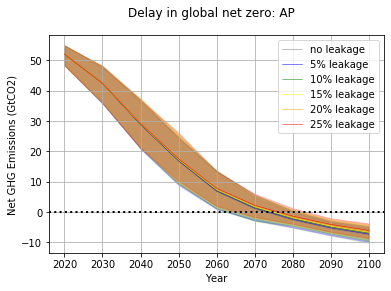

In [64]:
#plot 
ax=sns.lineplot(x='Year',y='Total_GHG',color='gray',linewidth=0.5, data=global_netzero_plot, label='no leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_5%BECCS_leakage:AP',color='blue',linewidth=0.5 ,data=global_netzero_plot,label='5% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_10%BECCS_leakage:AP',color='green',linewidth=0.5,data=global_netzero_plot,label='10% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_15%BECCS_leakage:AP',color='yellow',linewidth=0.5,data=global_netzero_plot,label='15% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_20%BECCS_leakage:AP',color='orange',linewidth=0.5,data=global_netzero_plot,label='20% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_25%BECCS_leakage:AP',color='red',linewidth=0.5,data=global_netzero_plot,label='25% leakage')
plt.axhline(linewidth=2, linestyle="dotted", color='black')
ax.set(xlabel='Year', ylabel='Net GHG Emissions (GtCO2)')
plt.grid(True)
plt.suptitle('Delay in global net zero: AP', fontsize = 12)
plt.savefig(plot_path + 'netzero_delay:AP.png', dpi = 800, transparent = True, bbox_inches='tight')

/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


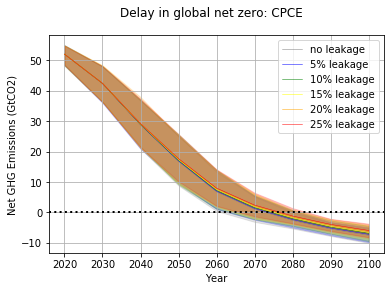

In [66]:
#GLOBAL delay in net zero w different amounts of leakage: CPCE 
global_netzero_plot=netzero_all_plot.loc[netzero_all_plot.Region==('World')]
global_netzero_plot.loc[:,'Total_GHG'
                       ]=global_netzero_plot.loc[:,'Total_GHG']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_5%BECCS_leakage:CPCE'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_5%BECCS_leakage:CPCE']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_10%BECCS_leakage:CPCE'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_10%BECCS_leakage:CPCE']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_15%BECCS_leakage:CPCE'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_15%BECCS_leakage:CPCE']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_20%BECCS_leakage:CPCE'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_20%BECCS_leakage:CPCE']*10**-3
global_netzero_plot.loc[:,'Total_GHG_w_25%BECCS_leakage:CPCE'
                       ]=global_netzero_plot.loc[:,'Total_GHG_w_25%BECCS_leakage:CPCE']*10**-3

ax=sns.lineplot(x='Year',y='Total_GHG',color='gray',linewidth=0.5, data=global_netzero_plot, label='no leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_5%BECCS_leakage:CPCE',color='blue',linewidth=0.5 ,data=global_netzero_plot,label='5% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_10%BECCS_leakage:CPCE',color='green',linewidth=0.5,data=global_netzero_plot,label='10% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_15%BECCS_leakage:CPCE',color='yellow',linewidth=0.5,data=global_netzero_plot,label='15% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_20%BECCS_leakage:CPCE',color='orange',linewidth=0.5,data=global_netzero_plot,label='20% leakage')
ax=sns.lineplot(x='Year',y='Total_GHG_w_25%BECCS_leakage:CPCE',color='red',linewidth=0.5,data=global_netzero_plot,label='25% leakage')
plt.axhline(linewidth=2, linestyle="dotted", color='black')
ax.set(xlabel='Year', ylabel='Net GHG Emissions (GtCO2)')
plt.grid(True)
plt.suptitle('Delay in global net zero: CPCE', fontsize = 12)
plt.savefig(plot_path + 'netzero_delay:CPCE.png', dpi = 800, transparent = True, bbox_inches='tight')

In [68]:
global_netzero_plot

,MODEL,Scenario,Year,Region,Total_GHG,TOTAL_CDR,BECCS,CO2_Emissions,5%_leakage:AP,10%_leakage:AP,15%_leakage:AP,20%_leakage:AP,25%_leakage:AP,5%_leakage:CPCE,10%_leakage:CPCE,15%_leakage:CPCE,20%_leakage:CPCE,25%_leakage:CPCE,Total_GHG_w_5%BECCS_leakage:AP,Total_GHG_w_10%BECCS_leakage:AP,Total_GHG_w_15%BECCS_leakage:AP,Total_GHG_w_20%BECCS_leakage:AP,Total_GHG_w_25%BECCS_leakage:AP,Total_GHG_w_5%BECCS_leakage:CPCE,Total_GHG_w_10%BECCS_leakage:CPCE,Total_GHG_w_15%BECCS_leakage:CPCE,Total_GHG_w_20%BECCS_leakage:CPCE,Total_GHG_w_25%BECCS_leakage:CPCE
99,REMIND,SSP1-19-SPA1-V17,2020,World,49.470000,690.684900,0.059800,50160.684900,0.001731,0.003462,0.005193,0.006925,0.008656,0.001619,0.003237,0.004856,0.006475,0.008093,49470.001731,49470.003462,49470.005193,49470.006925,49470.008656,49.470002,49.470003,49.470005,49.470006,49.470008
100,REMIND,SSP1-19-SPA1-V17,2030,World,37.090000,767.087100,424.200000,37857.087100,8.004400,16.008800,24.013200,32.017600,40.022000,10.508425,21.016849,31.525274,42.033699,52.542123,37098.004400,37106.008800,37114.013200,37122.017600,37130.022000,37.100508,37.111017,37.121525,37.132034,37.142542
101,REMIND,SSP1-19-SPA1-V17,2040,World,25.340000,3972.076700,3788.000000,29312.076700,81.130000,162.260000,243.390000,324.520000,405.650000,96.886855,193.773709,290.660564,387.547419,484.434273,25421.130000,25502.260000,25583.390000,25664.520000,25745.650000,25.436887,25.533774,25.630661,25.727547,25.824434
102,REMIND,SSP1-19-SPA1-V17,2050,World,11.810000,9838.009300,9330.000000,21648.009300,166.705000,333.410000,500.115000,666.820000,833.525000,239.362647,478.725294,718.087942,957.450589,1196.813236,11976.705000,12143.410000,12310.115000,12476.820000,12643.525000,12.049363,12.288725,12.528088,12.767451,13.006813
103,REMIND,SSP1-19-SPA1-V17,2060,World,0.854900,12008.173500,10940.000000,12863.073500,205.600000,411.200000,616.800000,822.400000,1028.000000,270.557077,541.114154,811.671230,1082.228307,1352.785384,1060.500000,1266.100000,1471.700000,1677.300000,1882.900000,1.125457,1.396014,1.666571,1.937128,2.207685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,IMAGE,SSP2-LF-SPA2-V17,2060,World,0.469496,15550.644907,12714.519672,16020.140604,287.736513,575.473026,863.209538,1150.946051,1438.682564,247.301144,494.602287,741.903431,989.204574,1236.505718,757.232210,1044.968723,1332.705235,1620.441748,1908.178261,0.716797,0.964098,1.211399,1.458700,1.706001
1130,IMAGE,SSP2-LF-SPA2-V17,2070,World,-1.805454,16573.262248,13032.749408,14767.808269,266.352149,532.704298,799.056446,1065.408595,1331.760744,244.627134,489.254267,733.881401,978.508535,1223.135669,-1539.101831,-1272.749682,-1006.397533,-740.045384,-473.693236,-1.560827,-1.316200,-1.071573,-0.826945,-0.582318
1131,IMAGE,SSP2-LF-SPA2-V17,2080,World,-1.985481,16285.754279,13220.857297,14300.273322,260.755307,521.510615,782.265922,1043.021229,1303.776537,227.909092,455.818183,683.727275,911.636366,1139.545458,-1724.725650,-1463.970342,-1203.215035,-942.459728,-681.704420,-1.757572,-1.529663,-1.301754,-1.073845,-0.845935
1132,IMAGE,SSP2-LF-SPA2-V17,2090,World,-2.461411,16623.317239,13840.149817,14161.906350,287.049372,574.098744,861.148116,1148.197488,1435.246860,239.432169,478.864339,718.296508,957.728678,1197.160847,-2174.361517,-1887.312145,-1600.262773,-1313.213401,-1026.164029,-2.221979,-1.982547,-1.743114,-1.503682,-1.264250


In [67]:
def get_year_netzero(main_df, scen, leakage_rate):
    
    interp_years=main_df.loc[main_df.Scenario==(scen)]['Year'].values
    interp_emissions=main_df.loc[main_df.Scenario==(scen)][leakage_rate].values
    netzero_year=np.interp(0, interp_emissions[::-1], interp_years[::-1])
    
    return netzero_year

In [77]:
def create_netzero_table_AP(main_df):
    scens=main_df.Scenario.unique()
    netzero_df=pd.DataFrame(columns=['Model', 'Scenario', 'NetZero_w_no_leakage',
                                     'NetZero_w_5%leakage','NetZero_w_10%leakage',
                                     'NetZero_w_15%leakage','NetZero_w_20%leakage', 
                                     'NetZero_w_25%leakage'])  
    netzero_df['Scenario']=scens
    netzero_df['Model']=['REMIND','REMIND','REMIND','REMIND','REMIND','REMIND','IMAGE','IMAGE']
    
    for i in np.arange(0,len(scens)):
        netzero_df.loc[i,'NetZero_w_no_leakage']=get_year_netzero(main_df, scens[i],'Total_GHG')
        netzero_df.loc[i,'NetZero_w_5%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_5%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_10%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_10%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_15%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_15%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_20%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_20%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_25%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_25%BECCS_leakage:AP')
        
    return netzero_df

In [91]:
Netzero_delay_AP=create_netzero_table_AP(global_netzero_plot)
Netzero_delay_AP=Netzero_delay_AP.round(2)

In [100]:
Netzero_delay_AP.to_excel(data_path+'netzero_delay_yrs_AP.xls')

,Model,Scenario,NetZero_w_no_leakage,NetZero_w_5%leakage,NetZero_w_10%leakage,NetZero_w_15%leakage,NetZero_w_20%leakage,NetZero_w_25%leakage
0,REMIND,SSP1-19-SPA1-V17,2062.17,2062.7,2063.22,2063.75,2064.28,2064.82
1,REMIND,SSP2-19-SPA2-V17,2054.19,2054.9,2055.62,2056.35,2057.1,2057.86
2,REMIND,SSP1-26-SPA1-V17,2087.17,2087.58,2087.99,2088.39,2088.81,2089.22
3,REMIND,SSP2-26-SPA2-V17,2083.68,2084.34,2085.01,2085.68,2086.35,2087.03
4,REMIND,SSP5-19-SPA5-V17,2057.38,2057.6,2057.83,2058.07,2058.3,2058.54
5,REMIND,SSP5-26-SPA5-V17,2076.57,2076.98,2077.4,2077.82,2078.24,2078.67
6,IMAGE,SSP1-19-SPA0-V17,2076.13,2076.66,2077.2,2077.75,2078.33,2078.92
7,IMAGE,SSP2-LF-SPA2-V17,2062.06,2063.3,2064.51,2065.7,2066.86,2068.01


In [80]:
def create_netzero_table_CPCE(main_df):
    scens=main_df.Scenario.unique()
    netzero_df=pd.DataFrame(columns=['Model', 'Scenario', 'NetZero_w_no_leakage',
                                     'NetZero_w_5%leakage','NetZero_w_10%leakage',
                                     'NetZero_w_15%leakage','NetZero_w_20%leakage', 
                                     'NetZero_w_25%leakage'])  
    netzero_df['Scenario']=scens
    netzero_df['Model']=['REMIND','REMIND','REMIND','REMIND','REMIND','REMIND','IMAGE','IMAGE']
    
    for i in np.arange(0,len(scens)):
        netzero_df.loc[i,'NetZero_w_no_leakage']=get_year_netzero(main_df, scens[i],'Total_GHG')
        netzero_df.loc[i,'NetZero_w_5%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_5%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_10%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_10%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_15%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_15%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_20%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_20%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_25%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_25%BECCS_leakage:CPCE')
        
    return netzero_df

In [81]:
Netzero_delay_CPCE=create_netzero_table_CPCE(global_netzero_plot)
Netzero_delay_CPCE

,Model,Scenario,NetZero_w_no_leakage,NetZero_w_5%leakage,NetZero_w_10%leakage,NetZero_w_15%leakage,NetZero_w_20%leakage,NetZero_w_25%leakage
0,REMIND,SSP1-19-SPA1-V17,2062.17,2062.85,2063.54,2064.22,2064.9,2065.58
1,REMIND,SSP2-19-SPA2-V17,2054.19,2054.95,2055.73,2056.51,2057.31,2058.11
2,REMIND,SSP1-26-SPA1-V17,2087.17,2087.65,2088.13,2088.61,2089.09,2089.57
3,REMIND,SSP2-26-SPA2-V17,2083.68,2084.39,2085.1,2085.82,2086.56,2087.3
4,REMIND,SSP5-19-SPA5-V17,2057.38,2057.65,2057.92,2058.2,2058.48,2058.76
5,REMIND,SSP5-26-SPA5-V17,2076.57,2077.05,2077.53,2078.03,2078.52,2079.02
6,IMAGE,SSP1-19-SPA0-V17,2076.13,2076.57,2077.01,2077.47,2077.94,2078.43
7,IMAGE,SSP2-LF-SPA2-V17,2062.06,2063.15,2064.23,2065.31,2066.38,2067.46


In [176]:
(Netzero_delay_AP['NetZero_w_5%leakage']-Netzero_delay_AP['NetZero_w_no_leakage']).mean()

0.5872895384465551

In [101]:
Netzero_delay_CPCE.to_excel(data_path+'netzero_delay_yrs_CPCE.xls')

In [177]:
#AP Median -all
Netzero_delay_AP[['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                         'NetZero_w_15%leakage','NetZero_w_20%leakage',
                         'NetZero_w_25%leakage']].median().round(2)

NetZero_w_no_leakage    2069.15
NetZero_w_5%leakage     2069.98
NetZero_w_10%leakage    2070.85
NetZero_w_15%leakage    2071.73
NetZero_w_20%leakage    2072.55
NetZero_w_25%leakage    2073.34
dtype: float64

In [265]:
#AP Median -1.5 compatible
Netzero_delay_AP.loc[Netzero_delay_AP.Scenario.isin(scen_15_all)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2062.063763
NetZero_w_5%leakage     2062.696346
NetZero_w_10%leakage    2063.223843
NetZero_w_15%leakage    2063.752901
NetZero_w_20%leakage    2064.283525
NetZero_w_25%leakage    2064.815724
dtype: float64

In [266]:
#AP Median -2 compatible
Netzero_delay_AP.loc[Netzero_delay_AP.Scenario.isin(scen_2)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2083.683036
NetZero_w_5%leakage     2084.341124
NetZero_w_10%leakage    2085.005162
NetZero_w_15%leakage    2085.675230
NetZero_w_20%leakage    2086.351411
NetZero_w_25%leakage    2087.033789
dtype: float64

In [178]:
#CPCE Median - all
Netzero_delay_CPCE[['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                         'NetZero_w_15%leakage','NetZero_w_20%leakage',
                         'NetZero_w_25%leakage']].median().round(2)

NetZero_w_no_leakage    2069.15
NetZero_w_5%leakage     2069.86
NetZero_w_10%leakage    2070.62
NetZero_w_15%leakage    2071.39
NetZero_w_20%leakage    2072.16
NetZero_w_25%leakage    2072.94
dtype: float64

In [267]:
#CPCE Median -1.5 compatible
Netzero_delay_CPCE.loc[Netzero_delay_CPCE.Scenario.isin(scen_15_all)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2062.063763
NetZero_w_5%leakage     2062.854286
NetZero_w_10%leakage    2063.536734
NetZero_w_15%leakage    2064.217751
NetZero_w_20%leakage    2064.897342
NetZero_w_25%leakage    2065.575511
dtype: float64

In [268]:
#CPCE Median -2 compatible
Netzero_delay_CPCE.loc[Netzero_delay_CPCE.Scenario.isin(scen_2)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2083.683036
NetZero_w_5%leakage     2084.388023
NetZero_w_10%leakage    2085.101726
NetZero_w_15%leakage    2085.824307
NetZero_w_20%leakage    2086.555932
NetZero_w_25%leakage    2087.296774
dtype: float64

# Regional Net Zero Delay
### countries w big burdens (+ new net zero after trading takes place, 2nd new net zero with leakage)  
### AP: CHN, EUR/ CPCE: USA, RUS

In [235]:
#IMAGE & REMIND have different region categorization
#IMAGE: use two regions 'CEU', 'WEU' for EUR!!
EUR_IMAGE=netzero_all_plot.loc[(netzero_all_plot.Region==('CEU'))|(netzero_all_plot.Region==('WEU'))].copy()
EUR_REMIND=netzero_all_plot.loc[(netzero_all_plot.Region==('EUR'))].copy()

In [240]:
#combine CEU values and WEU values and create new rows with EUR values

sumColums=['Total_GHG', 'TOTAL_CDR', 'BECCS', 'CO2_Emissions', '5%_leakage:AP', '10%_leakage:AP',
       '15%_leakage:AP', '20%_leakage:AP', '25%_leakage:AP', '5%_leakage:CPCE',
       '10%_leakage:CPCE', '15%_leakage:CPCE', '20%_leakage:CPCE',
       '25%_leakage:CPCE', 'Total_GHG_w_5%BECCS_leakage:AP',
       'Total_GHG_w_10%BECCS_leakage:AP', 'Total_GHG_w_15%BECCS_leakage:AP',
       'Total_GHG_w_20%BECCS_leakage:AP', 'Total_GHG_w_25%BECCS_leakage:AP',
       'Total_GHG_w_5%BECCS_leakage:CPCE', 'Total_GHG_w_10%BECCS_leakage:CPCE',
       'Total_GHG_w_15%BECCS_leakage:CPCE',
       'Total_GHG_w_20%BECCS_leakage:CPCE',
       'Total_GHG_w_25%BECCS_leakage:CPCE']

mask_reg = EUR_IMAGE.Region.isin(['CEU', 'WEU'])
for sce in EUR_IMAGE.Scenario.unique():
    mask_sce = (EUR_IMAGE.Scenario == sce)
    for year in EUR_IMAGE.Year.unique():
        mask_year = (EUR_IMAGE.Year == year)
        filtered_df = EUR_IMAGE.loc[mask_sce & mask_reg & mask_year,:]
        result = EUR_IMAGE.loc[mask_sce & mask_reg & mask_year, sumColums].sum(axis=0)
        idx = len(EUR_IMAGE)+1
        EUR_IMAGE.loc[idx,:] = filtered_df.iloc[0]
        EUR_IMAGE.loc[idx,sumColums] = result
        EUR_IMAGE.loc[idx,'Region'] = 'EUR'

In [245]:
EUR_IMAGE=EUR_IMAGE.loc[EUR_IMAGE.Region==('EUR')]
EUR_netzero=pd.concat([EUR_IMAGE, EUR_REMIND],ignore_index=True, sort=False)

In [186]:
#AP
CHN_netzero=netzero_all_plot.loc[netzero_all_plot.Region==('CHN')].copy()

#CPCE
USA_netzero=netzero_all_plot.loc[netzero_all_plot.Region==('USA')].copy()
RUS_netzero=netzero_all_plot.loc[netzero_all_plot.Region==('RUS')].copy()

In [247]:
EUR_netzero

,MODEL,Scenario,Year,Region,Total_GHG,TOTAL_CDR,BECCS,CO2_Emissions,5%_leakage:AP,10%_leakage:AP,15%_leakage:AP,20%_leakage:AP,25%_leakage:AP,5%_leakage:CPCE,10%_leakage:CPCE,15%_leakage:CPCE,20%_leakage:CPCE,25%_leakage:CPCE,Total_GHG_w_5%BECCS_leakage:AP,Total_GHG_w_10%BECCS_leakage:AP,Total_GHG_w_15%BECCS_leakage:AP,Total_GHG_w_20%BECCS_leakage:AP,Total_GHG_w_25%BECCS_leakage:AP,Total_GHG_w_5%BECCS_leakage:CPCE,Total_GHG_w_10%BECCS_leakage:CPCE,Total_GHG_w_15%BECCS_leakage:CPCE,Total_GHG_w_20%BECCS_leakage:CPCE,Total_GHG_w_25%BECCS_leakage:CPCE
0,IMAGE,SSP1-19-SPA0-V17,2020.0,EUR,3773.132568,378.506661,5.484093,4151.639229,0.618792,1.237584,1.856376,2.475168,3.093959,0.282703,0.565407,0.848110,1.130813,1.413517,3773.751360,3774.370152,3774.988944,3775.607736,3776.226528,3773.415272,3773.697975,3773.980678,3774.263382,3774.546085
1,IMAGE,SSP1-19-SPA0-V17,2030.0,EUR,1959.772980,665.507832,65.735437,2625.280812,11.703110,23.406220,35.109330,46.812440,58.515550,6.434207,12.868415,19.302622,25.736830,32.171037,1971.476090,1983.179200,1994.882309,2006.585419,2018.288529,1966.207187,1972.641395,1979.075602,1985.509810,1991.944017
2,IMAGE,SSP1-19-SPA0-V17,2040.0,EUR,1004.121582,861.078788,256.600799,1865.200370,16.052596,32.105193,48.157789,64.210386,80.262982,8.087816,16.175632,24.263448,32.351264,40.439080,1020.174179,1036.226775,1052.279372,1068.331968,1084.384565,1012.209398,1020.297214,1028.385030,1036.472846,1044.560662
3,IMAGE,SSP1-19-SPA0-V17,2050.0,EUR,400.056263,936.381324,615.125166,1336.437587,5.450250,10.900500,16.350749,21.800999,27.251249,0.000000,0.000000,0.000000,0.000000,0.000000,405.506513,410.956763,416.407012,421.857262,427.307512,400.056263,400.056263,400.056263,400.056263,400.056263
4,IMAGE,SSP1-19-SPA0-V17,2060.0,EUR,57.311310,1066.807433,854.556783,1124.118742,5.737514,11.475027,17.212541,22.950054,28.687568,0.000000,0.000000,0.000000,0.000000,0.000000,63.048823,68.786337,74.523851,80.261364,85.998878,57.311310,57.311310,57.311310,57.311310,57.311310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,REMIND,SSP5-26-SPA5-V17,2060.0,EUR,2030.000000,1066.552200,1034.000000,3096.552200,68.957026,137.914051,206.871077,275.828103,344.785129,39.076108,78.152217,117.228325,156.304433,195.380541,2098.957026,2167.914051,2236.871077,2305.828103,2374.785129,2069.076108,2108.152217,2147.228325,2186.304433,2225.380541
68,REMIND,SSP5-26-SPA5-V17,2070.0,EUR,1190.000000,1225.511100,1173.000000,2415.511100,100.452178,200.904356,301.356533,401.808711,502.260889,53.076050,106.152099,159.228149,212.304198,265.380248,1290.452178,1390.904356,1491.356533,1591.808711,1692.260889,1243.076050,1296.152099,1349.228149,1402.304198,1455.380248
69,REMIND,SSP5-26-SPA5-V17,2080.0,EUR,621.000000,1379.270700,1307.000000,2000.270700,128.205454,256.410908,384.616361,512.821815,641.027269,60.459887,120.919775,181.379662,241.839549,302.299437,749.205454,877.410908,1005.616361,1133.821815,1262.027269,681.459887,741.919775,802.379662,862.839549,923.299437
70,REMIND,SSP5-26-SPA5-V17,2090.0,EUR,10.020000,1379.172200,1334.000000,1389.192200,158.483419,316.966837,475.450256,633.933674,792.417093,65.193683,130.387366,195.581049,260.774732,325.968415,168.503419,326.986837,485.470256,643.953674,802.437093,75.213683,140.407366,205.601049,270.794732,335.988415


In [187]:
def create_regional_netzero_table_AP(main_df):
    scens=main_df.Scenario.unique()
    netzero_df=pd.DataFrame(columns=['Scenario', 'NetZero_w_no_leakage',
                                     'NetZero_w_5%leakage','NetZero_w_10%leakage',
                                     'NetZero_w_15%leakage','NetZero_w_20%leakage', 
                                     'NetZero_w_25%leakage'])  
    netzero_df['Scenario']=scens
    #netzero_df['Model']=['REMIND','REMIND','REMIND','REMIND','REMIND','REMIND','IMAGE','IMAGE']
    
    for i in np.arange(0,len(scens)):
        netzero_df.loc[i,'NetZero_w_no_leakage']=get_year_netzero(main_df, scens[i],'Total_GHG')
        netzero_df.loc[i,'NetZero_w_5%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_5%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_10%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_10%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_15%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_15%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_20%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_20%BECCS_leakage:AP')
        netzero_df.loc[i,'NetZero_w_25%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_25%BECCS_leakage:AP')
        
    return netzero_df

In [248]:
#CHN_netzero_yr=create_regional_netzero_table_AP(CHN_netzero)
EUR_netzero_yr=create_regional_netzero_table_AP(EUR_netzero)

In [252]:
CHN_netzero_yr.to_excel(data_path+'CHN_netzero_yr.xls')
# [['Scenario','NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
#                 'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

In [259]:
CHN_netzero_yr.loc[CHN_netzero_yr.Scenario.isin(scen_15_all)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2057.787780
NetZero_w_5%leakage     2058.543418
NetZero_w_10%leakage    2059.314490
NetZero_w_15%leakage    2060.251912
NetZero_w_20%leakage    2065.951842
NetZero_w_25%leakage    2067.752656
dtype: float64

In [260]:
CHN_netzero_yr.loc[CHN_netzero_yr.Scenario.isin(scen_2)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2069.760855
NetZero_w_5%leakage     2071.460666
NetZero_w_10%leakage    2073.890901
NetZero_w_15%leakage    2076.055132
NetZero_w_20%leakage    2076.843496
NetZero_w_25%leakage    2077.630997
dtype: float64

In [253]:
EUR_netzero_yr.to_excel(data_path+'EUR_netzero_yr.xls')

In [271]:
EUR_netzero_yr[['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2063.817775
NetZero_w_5%leakage     2093.842700
NetZero_w_10%leakage    2096.279791
NetZero_w_15%leakage    2098.129693
NetZero_w_20%leakage    2100.000000
NetZero_w_25%leakage    2100.000000
dtype: float64

In [257]:
EUR_netzero_yr.loc[EUR_netzero_yr.Scenario.isin(scen_15_all)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2062.598823
NetZero_w_5%leakage     2066.060994
NetZero_w_10%leakage    2068.059922
NetZero_w_15%leakage    2070.668006
NetZero_w_20%leakage    2092.157584
NetZero_w_25%leakage    2100.000000
dtype: float64

In [258]:
EUR_netzero_yr.loc[EUR_netzero_yr.Scenario.isin(scen_2)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2090.426842
NetZero_w_5%leakage     2098.294517
NetZero_w_10%leakage    2100.000000
NetZero_w_15%leakage    2100.000000
NetZero_w_20%leakage    2100.000000
NetZero_w_25%leakage    2100.000000
dtype: float64

In [196]:
def create_regional_netzero_table_CPCE(main_df):
    scens=main_df.Scenario.unique()
    netzero_df=pd.DataFrame(columns=['Scenario', 'NetZero_w_no_leakage',
                                     'NetZero_w_5%leakage','NetZero_w_10%leakage',
                                     'NetZero_w_15%leakage','NetZero_w_20%leakage', 
                                     'NetZero_w_25%leakage'])  
    netzero_df['Scenario']=scens
    #netzero_df['Model']=['REMIND','REMIND','REMIND','REMIND','REMIND','REMIND','IMAGE','IMAGE']
    
    for i in np.arange(0,len(scens)):
        netzero_df.loc[i,'NetZero_w_no_leakage']=get_year_netzero(main_df, scens[i],'Total_GHG')
        netzero_df.loc[i,'NetZero_w_5%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_5%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_10%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_10%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_15%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_15%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_20%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_20%BECCS_leakage:CPCE')
        netzero_df.loc[i,'NetZero_w_25%leakage']=get_year_netzero(main_df, scens[i],'Total_GHG_w_25%BECCS_leakage:CPCE')
        
    return netzero_df

In [269]:
USA_netzero_yr=create_regional_netzero_table_CPCE(USA_netzero)
USA_netzero_yr.to_excel(data_path+'USA_netzero_yr.xls')

In [261]:
USA_netzero_yr.loc[USA_netzero_yr.Scenario.isin(scen_15_all)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2051.345896
NetZero_w_5%leakage     2052.461451
NetZero_w_10%leakage    2053.613992
NetZero_w_15%leakage    2054.805389
NetZero_w_20%leakage    2056.037640
NetZero_w_25%leakage    2057.312884
dtype: float64

In [262]:
USA_netzero_yr.loc[USA_netzero_yr.Scenario.isin(scen_2)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2067.880013
NetZero_w_5%leakage     2068.828446
NetZero_w_10%leakage    2069.835123
NetZero_w_15%leakage    2072.381473
NetZero_w_20%leakage    2075.499267
NetZero_w_25%leakage    2078.983234
dtype: float64

In [270]:
RUS_netzero_yr=create_regional_netzero_table_CPCE(RUS_netzero)
RUS_netzero_yr.to_excel(data_path+'RUS_netzero_yr.xls')

In [263]:
RUS_netzero_yr.loc[RUS_netzero_yr.Scenario.isin(scen_15_all)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2078.490634
NetZero_w_5%leakage     2082.802132
NetZero_w_10%leakage    2086.498906
NetZero_w_15%leakage    2090.259436
NetZero_w_20%leakage    2093.584465
NetZero_w_25%leakage    2099.925312
dtype: float64

In [264]:
RUS_netzero_yr.loc[RUS_netzero_yr.Scenario.isin(scen_2)][['NetZero_w_no_leakage','NetZero_w_5%leakage','NetZero_w_10%leakage',
                'NetZero_w_15%leakage','NetZero_w_20%leakage','NetZero_w_25%leakage']].median()

NetZero_w_no_leakage    2100.0
NetZero_w_5%leakage     2100.0
NetZero_w_10%leakage    2100.0
NetZero_w_15%leakage    2100.0
NetZero_w_20%leakage    2100.0
NetZero_w_25%leakage    2100.0
dtype: float64

In [202]:
#making df for USA 
#USA_netzero['Total_CDR-5%leakage:CPCE']=USA_netzero['TOTAL_CDR']-USA_netzero['5%_leakage:AP']
USA_netzero['Total_CDR-20%leakage:CPCE']=USA_netzero['TOTAL_CDR']-USA_netzero['20%_leakage:CPCE']

USA_netzero.loc[:,'Total_CDR-20%leakage:CPCE'] = USA_netzero.loc[:,'Total_CDR-20%leakage:CPCE']*(-1)
USA_netzero.loc[:,'TOTAL_CDR'] = USA_netzero.loc[:,'TOTAL_CDR']*(-1)

# USA_netzero.loc[:,'Total_GHG_w_5%BECCS_leakage:AP'] = USA_netzero.loc[:,'Total_GHG_w_5%BECCS_leakage:AP']*10**-3
# USA_netzero.loc[:,'CO2_Emissions'] = USA_netzero.loc[:,'CO2_Emissions']*10**-3
# USA_netzero.loc[:,'Total_GHG'] = USA_netzero.loc[:,'Total_GHG']*10**-3

/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be s

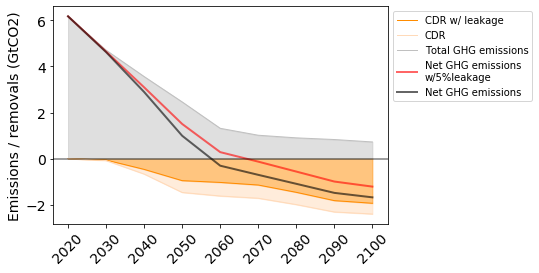

In [210]:
#for a single scene: e.g. SSP5: 'SSP5-26-SPA5-V17'
single_scen= USA_netzero.loc[USA_netzero.Scenario==('SSP1-19-SPA1-V17')]
single_scen['Total_CDR-20%leakage:CPCE']=single_scen['Total_CDR-20%leakage:CPCE'].values*10**-3
single_scen['TOTAL_CDR']=single_scen['TOTAL_CDR'].values*10**-3
single_scen['CO2_Emissions']=single_scen['CO2_Emissions'].values*10**-3
single_scen['Total_GHG_w_20%BECCS_leakage:CPCE']=single_scen['Total_GHG_w_20%BECCS_leakage:CPCE'].values*10**-3
single_scen['Total_GHG']=single_scen['Total_GHG'].values*10**-3

sns.lineplot(x='Year',y='Total_CDR-20%leakage:CPCE',data=single_scen, linewidth = 1, label = 'CDR w/ leakage',color='darkorange')
sns.lineplot(x='Year',y='TOTAL_CDR',data=single_scen, linewidth = 1, label = 'CDR',color='peachpuff')
sns.lineplot(x='Year', y='CO2_Emissions',data = single_scen, linewidth = 1, label = 'Total GHG emissions',color='silver')
sns.lineplot(x='Year',y='Total_GHG_w_20%BECCS_leakage:CPCE',data=single_scen, linewidth = 2, color = 'r', label = 'Net GHG emissions\nw/5%leakage', alpha = 0.6)
sns.lineplot(x='Year',y='Total_GHG',data=single_scen, linewidth = 2, color = 'black', label = 'Net GHG emissions', alpha = 0.6)

plt.fill_between(np.arange(2020,2110,10), single_scen['Total_CDR-20%leakage:CPCE'].values, alpha=0.5, color='darkorange') 
plt.fill_between(np.arange(2020,2110,10), single_scen["CO2_Emissions"].values, alpha=0.5,color='silver') 
plt.fill_between(np.arange(2020,2110,10), single_scen['Total_CDR-20%leakage:CPCE'].values, 
                 single_scen['TOTAL_CDR'].values, alpha=0.5, color='peachpuff') 

# plt.line(x = np.arange(2020,2100,10), y = 0)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
plt.ylabel('Emissions / removals (GtCO2)', fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.xlabel("", fontsize = 14)

plt.legend(loc = 'upper left', bbox_to_anchor=(1,1))
# plt.legend(loc='upper right', fontsize = 14)
plt.savefig(plot_path + 'USA-Netzero_SSP1-19-SPA1-V17_20%leakage.png',bbox_inches="tight")
### delay 2057.63 to 2066.81


In [145]:
#making df for CHN
CHN_netzero=netzero_all_plot.loc[netzero_all_plot.Region==('CHN')].copy()
CHN_netzero['Total_CDR-25%leakage:AP']=CHN_netzero['TOTAL_CDR']-CHN_netzero['25%_leakage:AP']
CHN_netzero.loc[:,'Total_CDR-25%leakage:AP'] = CHN_netzero.loc[:,'Total_CDR-25%leakage:AP']*(-1)
CHN_netzero.loc[:,'TOTAL_CDR'] = CHN_netzero.loc[:,'TOTAL_CDR']*(-1)

# USA_netzero.loc[:,'Total_GHG_w_5%BECCS_leakage:AP'] = USA_netzero.loc[:,'Total_GHG_w_5%BECCS_leakage:AP']*10**-3
# USA_netzero.loc[:,'CO2_Emissions'] = USA_netzero.loc[:,'CO2_Emissions']*10**-3
# USA_netzero.loc[:,'Total_GHG'] = USA_netzero.loc[:,'Total_GHG']*10**-3

/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be s

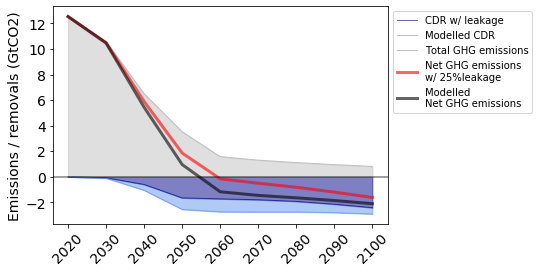

In [185]:
#for a single scene: e.g. SSP5: 'SSP5-26-SPA5-V17'
single_scen= CHN_netzero.loc[CHN_netzero.Scenario==('SSP5-19-SPA5-V17')]
single_scen['Total_CDR-25%leakage:AP']=single_scen['Total_CDR-25%leakage:AP'].values*10**-3
single_scen['TOTAL_CDR']=single_scen['TOTAL_CDR'].values*10**-3
single_scen['CO2_Emissions']=single_scen['CO2_Emissions'].values*10**-3
single_scen['Total_GHG_w_25%BECCS_leakage:AP']=single_scen['Total_GHG_w_25%BECCS_leakage:AP'].values*10**-3
single_scen['Total_GHG']=single_scen['Total_GHG'].values*10**-3

sns.lineplot(x='Year',y='Total_CDR-25%leakage:AP',data=single_scen, linewidth = 1, label = 'CDR w/ leakage',color='darkblue',alpha = 0.6)
sns.lineplot(x='Year',y='TOTAL_CDR',data=single_scen, linewidth = 1, label = 'Modelled CDR',color='cornflowerblue',alpha = 0.6)
sns.lineplot(x='Year', y='CO2_Emissions',data = single_scen, linewidth = 1, label = 'Total GHG emissions', color='silver')
sns.lineplot(x='Year',y='Total_GHG_w_25%BECCS_leakage:AP',data=single_scen, linewidth = 3, color = 'r', label = 'Net GHG emissions\nw/ 25%leakage', alpha = 0.6)
sns.lineplot(x='Year',y='Total_GHG',data=single_scen, linewidth = 3, color = 'black', label = 'Modelled\nNet GHG emissions', alpha = 0.6)

plt.fill_between(np.arange(2020,2110,10), single_scen['Total_CDR-25%leakage:AP'].values, alpha=0.5, color='darkblue') 
plt.fill_between(np.arange(2020,2110,10), single_scen["CO2_Emissions"].values, alpha=0.5, color='silver') 
plt.fill_between(np.arange(2020,2110,10), single_scen['Total_CDR-25%leakage:AP'].values, single_scen['TOTAL_CDR'].values, alpha=0.5, color='cornflowerblue') 

# plt.line(x = np.arange(2020,2100,10), y = 0)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
plt.ylabel('Emissions / removals (GtCO2)', fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.xlabel("", fontsize = 14)

plt.legend(loc = 'upper left', bbox_to_anchor=(1,1))
# plt.legend(loc='upper right', fontsize = 14)

plt.savefig(plot_path + 'CHN-Netzero_SSP5-19-SPA5-V17_25%leakage.png',bbox_inches="tight")
